In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy import units as u
from astropy import constants as const
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update({
    'text.usetex': False,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.family': 'serif',
    'font.weight': 'normal',
    'figure.facecolor': 'lightgray',
    'mathtext.fontset': 'dejavuserif'
})

In [2]:
# Definimos la expresión para el cálculo de la velocidad de escape

def calculate_escape_vel(mass, diameter):
    return np.sqrt(4 * const.G * mass / diameter).to(u.km / u.s)

In [4]:
# Creamos linspaces para la masa y el diámetro

mass_array = np.linspace(10 ** 7, 10 ** 9, 1000) * u.M_sun
diameter_array = np.linspace(1, 10, 500) * u.kpc

# Calculamos las velocidades de escape para cada combinación de masa y diámetro
escape_velocities = np.array([[calculate_escape_vel(mass, diameter).value
                               for mass in mass_array] for diameter in diameter_array])

escape_velocities


array([[ 13.1162758 ,  13.75083168,  14.35736929, ..., 131.0327124 ,
        131.09775131, 131.16275798],
       [ 12.9995691 ,  13.62847879,  14.22961952, ..., 129.8668025 ,
        129.93126271, 129.99569096],
       [ 12.88592328,  13.50933487,  14.10522026, ..., 128.73147113,
        128.79536781, 128.8592328 ],
       ...,
       [  4.15523177,   4.35625886,   4.54840977, ...,  41.51111931,
         41.53172362,  41.55231771],
       [  4.1514761 ,   4.35232149,   4.54429873, ...,  41.47359984,
         41.49418552,  41.514761  ],
       [  4.14773059,   4.34839478,   4.54019882, ...,  41.43618192,
         41.45674903,  41.47730594]])

In [5]:
# Ponemos todos los valores en un solo array
escape_velocities = escape_velocities.flatten()
escape_velocities

array([13.1162758 , 13.75083168, 14.35736929, ..., 41.43618192,
       41.45674903, 41.47730594])

In [9]:
# Asumimos que la distribución de velocidades de escape sigue una distribución normal,
# así que ajustamos una gaussiana a los datos

escape_data = escape_velocities

# Calculamos el histograma eligiendo 800 bins
bin_count = 40
hist, bin_edges = np.histogram(escape_data, bins=bin_count, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Utilizar un kernel Gaussiano para convolucionar el histograma y suavizarlo
gaussian_kernel = Gaussian1DKernel(stddev=0.5)  # Elegimos sigma 0.5, arbitrario pero conveniente
smoothed_hist = convolve(hist, gaussian_kernel)

# Ajustamos una Gaussiana al histograma suavizado
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Calculamos el promedio ponderado y la desviación estándar para el histograma
weighted_mean = np.sum(bin_centers * hist) / np.sum(hist)
weighted_std = np.sqrt(np.sum(hist * (bin_centers - weighted_mean) ** 2) / np.sum(hist))

# Usamos estos valores como priors
initial_guess = [max(hist), weighted_mean, weighted_std]

# Hacemos el ajuste utilizando curve_fit
params, _ = curve_fit(gaussian, bin_centers, smoothed_hist, p0=initial_guess)


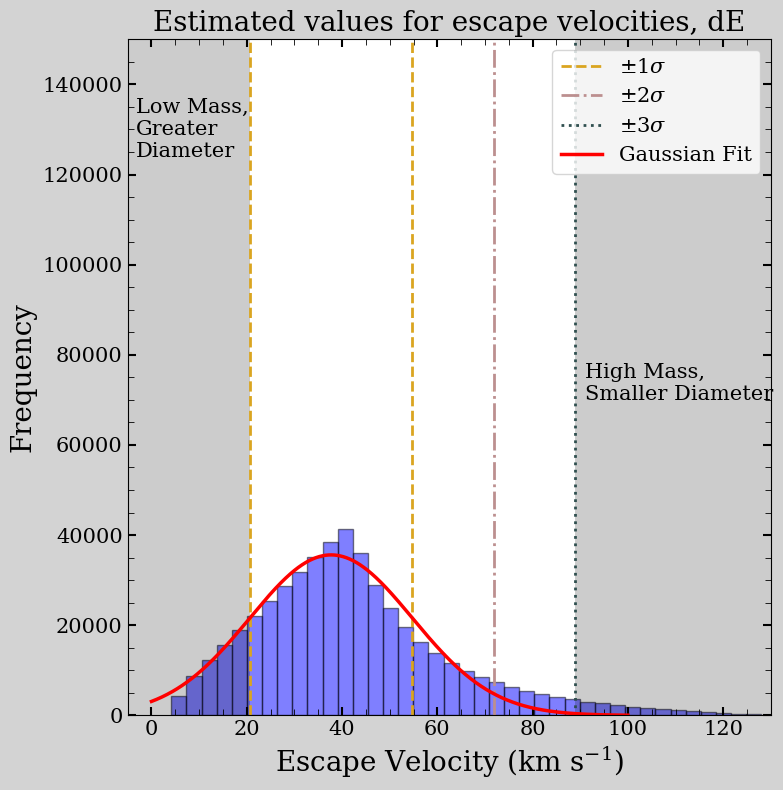

In [12]:
fig, ax= plt.subplots(figsize=(8, 8))
ax.hist(escape_velocities, bins=40, color='blue', alpha=0.5, edgecolor='black')


# Añadimos líneas verticales para 1, 2 y 3 sigma
sigma = params[2]
ax.axvline(params[1] + sigma, color='goldenrod', linestyle='--', label=r'$\pm 1 \sigma$', linewidth=2)
ax.axvline(params[1] - sigma, color='goldenrod', linestyle='--', linewidth=2)
ax.axvline(params[1] + 2*sigma, color='rosybrown', linestyle='-.', label=r'$\pm 2 \sigma$', linewidth=2)
ax.axvline(params[1] + 3*sigma, color='darkslategray', linestyle=':', label=r'$\pm 3 \sigma$', linewidth=2)

ax.plot(np.linspace(0, 100, 1000), gaussian(np.linspace(0, 100, 1000), *params), color='red', label='Gaussian Fit', linewidth=2.5)


ax.set_xlim(-5, 130)
ax.set_ylim(0, 150000)

ax.set_ylabel(r'Frequency', fontsize=20)
ax.set_xlabel(r"Escape Velocity (km s$^{-1}$)", fontsize=20)
ax.set_title(r'Estimated values for escape velocities, dE', fontsize=20)

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5000))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

rect = patches.Rectangle((params[1] - 3*sigma, 0),  2 *sigma, 150000, linewidth=1, edgecolor='none', facecolor='black', alpha=0.2)
rect_1 = patches.Rectangle((params[1] + 3*sigma, 0), 3 *sigma, 150000, linewidth=1, edgecolor='none', facecolor='black', alpha=0.2)
ax.add_patch(rect)
ax.add_patch(rect_1)

ax.text(params[1] - 2.4*sigma, 124000, 'Low Mass,\nGreater\nDiameter', fontsize=15, color='black')
ax.text(params[1] + 6.25*sigma/2, 70000, 'High Mass,\nSmaller Diameter', fontsize=15, color='black')


ax.grid(False, which='both')
ax.legend(fontsize=15, markerscale=1)


plt.tight_layout()

Observando la distribución de velocidades de escape, notamos que los valores van desde cerca de $5$ km/s hasta $120$ km/s. Sin embargo, podemos notar que los valores muy bajos de velocidades de escape corresponden a galaxias de baja masa y de gran diámetro, y los valores más altos de velocidades de escape corresponden a galaxias de alta masa y menor diámetro. Galaxias con estas propiedades pueden ser muy inestables, ya sea porque se disuelvan debido a la baja densidad de masa, o colapsen debido a la alta densidad de masa. En base a esto, podemos hacer una suposición educada sobre los valores que puede tomar la velocidad de escape en galaxias elípticas enanas estables. Así, obtenemos que el rango de velocidades de escape toma valores entre $20$ km/s y $90$ km/s.